# Plot MKE & EKE (Figure 2)

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.pylab as pylab

In [2]:
import numpy as np
import xarray as xr
from xgcm import Grid
from dask.diagnostics import ProgressBar

In [3]:
# Filter Specs
filter_fac = 32  

run = 'nw2_0.03125deg_N15_baseline_hmix20'
basepath = '/glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/'
workpath = '/glade/work/noraloose/' 
scratchpath = '/glade/scratch/noraloose/filtered_data/' 

In [4]:
st = xr.open_dataset('%s/%s/static.nc' % (basepath,run), decode_times=False)

# for 5 day averages
nr_days0 = 100  # that's how many days are saved per netcdf
chunks = {'time': 1}
end_time = 2900
ds_lorenz = xr.open_zarr('%s/%s/lorenz_cycle_%08d_fac%i' % (scratchpath, run, end_time-nr_days0+2, filter_fac), 
                  chunks=chunks, decode_times=False)

# for 500 day averages
ds_lorenz_averaged = xr.open_dataset('%s/%s/lorenz_cycle_fac%i_500days.nc' % (workpath, run, filter_fac), decode_times=False)
ds_bleck_averaged = xr.open_dataset('%s/%s/bleck_cycle_fac%i_500days.nc' % (workpath, run, filter_fac), decode_times=False)

### Prepare NeverWorld2 grid info

In [5]:
coords = {'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}
         }

grid = Grid(st, coords=coords, periodic=['X'])

st['dxT'] = grid.interp(st.dxCu,'X')
st['dyT'] = grid.interp(st.dyCv,'Y')

## Plotting

In [6]:
import cmocean
from matplotlib.ticker import MultipleLocator

In [7]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 12}
pylab.rcParams.update(params)

In [8]:
extent = [0, 60, -70, 70]

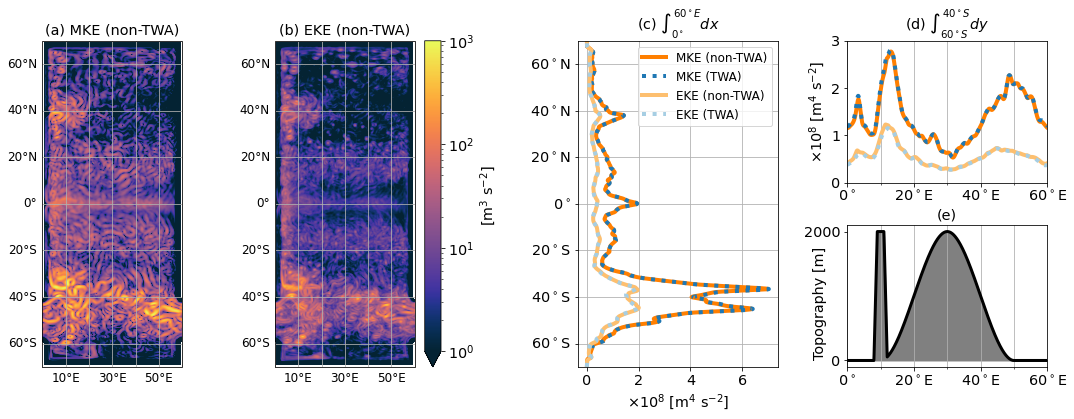

In [11]:
vmin = 1
vmax = 1e3

fig = plt.figure(figsize=(20,6))
gs = fig.add_gridspec(2, 21)

# 5-day average of MKE (non-TWA)
ax0 = fig.add_subplot(gs[:, 0:5],  projection=ccrs.PlateCarree())
p = ds_lorenz['MKE'].isel(time=-1).where(st.wet).plot(
    ax=ax0,
    add_colorbar=False,
    norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
    cmap=cmocean.cm.thermal,
    transform=ccrs.PlateCarree()
)
ax0.set(title='(a) MKE (non-TWA)')

# 5-day average of EKE (non-TWA)
ax1 = fig.add_subplot(gs[:, 5:9],  projection=ccrs.PlateCarree())
p = ds_lorenz['EKE'].isel(time=-1).where(st.wet).plot(
    ax=ax1,
    cbar_kwargs={"label":   '[m$^3$ s$^{-2}$]'},
    norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
    cmap=cmocean.cm.thermal,
    transform=ccrs.PlateCarree()
)
ax1.set(title='(b) EKE (non-TWA)')

for ax in [ax0, ax1]:
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

# zonal integral of 500 day averaged energies
ax2 = fig.add_subplot(gs[:, 11:15])

(ds_lorenz_averaged['MKE'] * st.dxT).sum(dim='xh').plot(ax=ax2, y='yh', color='#ff7f00', linewidth=4, label='MKE (non-TWA)')
(ds_bleck_averaged['MKE_TWA'] * st.dxT).sum(dim='xh').plot(ax=ax2, y='yh', color='#1f78b4', linewidth=4, linestyle='dotted', label='MKE (TWA)')
(ds_lorenz_averaged['EKE'] * st.dxT).sum(dim='xh').plot(ax=ax2, y='yh', color='#fdbf6f', linewidth=4, label='EKE (non-TWA)')
(ds_bleck_averaged['EKE_TWA'] * st.dxT).sum(dim='xh').plot(ax=ax2, y='yh',  color='#a6cee3', linewidth=4, linestyle='dotted', label='EKE (TWA)')

ax2.legend(fontsize=12)
ax2.grid('on')
ax2.set(ylabel='', xlabel=r'$\times 10^8$ [m$^4$ s$^{-2}$]', title=r'(c) $\int_{0^\circ}^{60^\circ E} dx$')
ax2.set_yticks(ticks=np.arange(-60.01, 60, 20))
ax2.set(yticklabels=[r'60$^\circ$S', r'40$^\circ$S', r'20$^\circ$S',  r'0$^\circ$',  r'20$^\circ$N', r'40$^\circ$N', r'60$^\circ$N'])
ax2.set_xticks(ticks=np.arange(-0.01, 6, 2)*1e8)
ax2.set(xticklabels=['0', '2', '4', '6'])
ax2.set_ylim(-70, 70)

# meridional integral of 500 day averaged energies across channel
ax3 = fig.add_subplot(gs[0, 16:20])
yslice = slice(-60, -40)

(ds_lorenz_averaged['MKE'] * st.dyT).sel(yh=yslice).sum(dim='yh').plot(ax=ax3, color='#ff7f00', linewidth=4, label='MKE (non-TWA)')
(ds_bleck_averaged['MKE_TWA'] * st.dyT).sel(yh=yslice).sum(dim='yh').plot(ax=ax3, color='#1f78b4', linewidth=4, linestyle='dotted', label='MKE (TWA)')
(ds_lorenz_averaged['EKE'] * st.dyT).sel(yh=yslice).sum(dim='yh').plot(ax=ax3, color='#fdbf6f', linewidth=4, label='EKE (non-TWA)')
(ds_bleck_averaged['EKE_TWA'] * st.dyT).sel(yh=yslice).sum(dim='yh').plot(ax=ax3, color='#a6cee3', linewidth=4, linestyle='dotted', label='EKE (TWA)')

ax3.set_xticks(ticks=np.arange(0, 61, 20))
ax3.set(xticklabels=[r'0$^\circ$', r'20$^\circ$E', r'40$^\circ$E',  r'60$^\circ$E'])
ax3.set_xlim(0, 60)
ax3.grid(axis='x', which='both')
ax3.xaxis.set_minor_locator(MultipleLocator(10))

ax3.set(xlabel='', ylabel=r'$\times 10^8$ [m$^4$ s$^{-2}$]', title=r'(d) $\int_{60^\circ S}^{40^\circ S} dy$')
ax3.set_yticks(ticks=np.arange(0, 3.01)*1e8)
ax3.set(yticklabels=['0', '1', '2', '3'])

# topography
ax4 = fig.add_subplot(gs[1, 16:20])

topo = (4000 - st.depth_ocean).sel(yh=-50, method='nearest')
topo.plot(ax=ax4, linewidth=3, color='k')
ax4.fill_between(st.xh, 0, topo, color='gray')
ax4.set_xlim(0, 60)  
ax4.set_xticks(ticks=np.arange(0, 61, 20))
ax4.set(xticklabels=[r'0$^\circ$', r'20$^\circ$E', r'40$^\circ$E',  r'60$^\circ$E'])
ax4.set_yticks(ticks=[0, 2000])
ax4.grid(axis='x', which='both')
ax4.xaxis.set_minor_locator(MultipleLocator(10))

ax4.set(ylabel='Topography [m]', xlabel='', title='(e)')
ax4.yaxis.set_label_coords(-0.1,0.45)

plt.subplots_adjust(wspace=0.4, hspace=0.3)  

figname = 'figures/MKE_EKE_fac%i.png' %(filter_fac)
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)